In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd '/content/gdrive/My Drive/LDS0_K287_Online_PhamMinhQuang/Project3/'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS0_K287_Online_PhamMinhQuang/Project3


In [ ]:
!pip install pandas-profiling

In [ ]:
!pip install underthesea

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import re
from underthesea import word_tokenize, pos_tag, sent_tokenize
from sklearn.metrics import confusion_matrix, accuracy_score

<ipython-input-4-38bfecedbdf1>:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [ ]:
df = pd.read_csv('Sendo_reviews.csv')

In [ ]:
df = df[['content','rating']]

### EDA

In [ ]:
df.shape

(7224, 2)

In [ ]:
# check null
df.isnull().sum()

content    1916
rating        0
dtype: int64

In [ ]:
# không có content thì ko biểu lộ cảm xúc gì cả, nên drop
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5308 entries, 1 to 7223
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  5308 non-null   object
 1   rating   5308 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 124.4+ KB


In [ ]:
# có dup nhưng có thể là do user chọn recommended feedback do hệ thống shendo đề xuất nên feedback giống nhau
df.duplicated().sum()

3007

In [ ]:
profile=pandas_profiling.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Xử lý theo cách đếm từ

In [ ]:
df_sub = df.copy()

In [ ]:
df_sub.head()

,content,rating
1,Shop phục vụ khá tốt.,4
2,Sản phẩm gần giống mô tả,3
5,Giao hàng nhanh bất ngờ.,5
6,Sản phẩm/dịch vụ giống mô tả.,4
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,5


In [ ]:
class NormalClassifier:

  def __init__(self):
    self.df = None
    self.positive_words = [
    "thích", "tốt", "xuất sắc", "tuyệt vời", "tuyệt hảo", "đẹp", "ổn"
    "hài lòng", "ưng ý", "hoàn hảo", "chất lượng", "thú vị", "nhanh"
    "tiện lợi", "dễ sử dụng", "hiệu quả", "ấn tượng",
    "nổi bật", "tận hưởng", "tốn ít thời gian", "thân thiện", "hấp dẫn",
    "gợi cảm", "tươi mới", "lạ mắt", "cao cấp", "độc đáo",
    "hợp khẩu vị", "rất tốt", "rất thích", "tận tâm", "đáng tin cậy", "đẳng cấp",
    "hấp dẫn", "an tâm", "không thể cưỡng lại", "thỏa mãn", "thúc đẩy",
    "cảm động", "phục vụ tốt", "làm hài lòng", "gây ấn tượng", "nổi trội",
    "sáng tạo", "quý báu", "phù hợp", "tận tâm",
    "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", "cẩn thận",
    "vui vẻ", "sáng sủa", "hào hứng", "đam mê", "vừa vặn", "đáng tiền"
    ]
    self.negative_words = [
    "kém", "tệ", "đau", "xấu",
    "buồn", "rối", "thô", "lâu"
    "tối", "chán", "ít", "mờ", "mỏng",
    "lỏng lẻo", "khó", "cùi", "yếu",
    "kém chất lượng", "không thích", "không thú vị", "không ổn"
    "không hợp", "không đáng tin cậy", "không chuyên nghiệp",
    "không phản hồi", "không an toàn", "không phù hợp", "không thân thiện", "không linh hoạt", "không đáng giá",
    "không ấn tượng", "không tốt", "chậm", "khó khăn", "phức tạp",
    "khó hiểu", "khó chịu", "gây khó dễ", "rườm rà", "khó truy cập",
    "thất bại", "tồi tệ", "khó xử", "không thể chấp nhận", "tồi tệ","không rõ ràng",
    "không chắc chắn", "rối rắm", "không tiện lợi", "không đáng tiền", "chưa đẹp", "không đẹp"
    ]
    self.negative_emojis = [
    "😞", "😔", "🙁", "☹️", "😕",
    "😢", "😭", "😖", "😣", "😩",
    "😠", "😡", "🤬", "😤", "😰",
    "😨", "😱", "😪", "😓", "🥺",
    "😒", "🙄", "😑", "😬", "😶",
    "🤯", "😳", "🤢", "🤮", "🤕",
    "🥴", "🤔", "😷", "🙅‍♂️", "🙅‍♀️",
    "🙆‍♂️", "🙆‍♀️", "🙇‍♂️", "🙇‍♀️", "🤦‍♂️",
    "🤦‍♀️", "🤷‍♂️", "🤷‍♀️", "🤢", "🤧",
    "🤨", "🤫", "👎", "👊", "✊", "🤛", "🤜",
    "🤚", "🖕"
    ]
    self.positive_emojis = [
    "😄", "😃", "😀", "😁", "😆",
    "😅", "🤣", "😂", "🙂", "🙃",
    "😉", "😊", "😇", "🥰", "😍",
    "🤩", "😘", "😗", "😚", "😙",
    "😋", "😛", "😜", "🤪", "😝",
    "🤗", "🤭", "🥳", "😌", "😎",
    "🤓", "🧐", "👍", "🤝", "🙌", "👏", "👋",
    "🤙", "✋", "🖐️", "👌", "🤞",
    "✌️", "🤟", "👈", "👉", "👆",
    "👇", "☝️"
    ]

  @property
  def df(self):
      return self.__df

  @df.setter
  def df(self, value):
      self.__df = value

  @staticmethod
  def find_words(document, list_of_words):
    document_lower = document.lower()
    word_count = 0
    word_list = []
    for word in list_of_words:
        if word in document_lower:
            word_count += document_lower.count(word)
            word_list.append(word)
    return word_count, word_list

  def mainProcessor(self):
    self.df['positive_count'] = self.df['content'].apply(lambda x : self.find_words(x, self.positive_words)[0])
    self.df['positive_words'] = self.df['content'].apply(lambda x : self.find_words(x, self.positive_words)[1])
    self.df['positive_emoji_count'] = self.df['content'].apply(lambda x : self.find_words(x, self.positive_emojis)[0])
    self.df['positive_emoji'] = self.df['content'].apply(lambda x : self.find_words(x, self.positive_emojis)[1])
    # ---------------------------------------------------------------------------------------------------------------------------------------
    self.df['negative_count'] = self.df['content'].apply(lambda x : self.find_words(x, self.negative_words)[0])
    self.df['negative_words'] = self.df['content'].apply(lambda x : self.find_words(x, self.negative_words)[1])
    self.df['negative_emoji_count'] = self.df['content'].apply(lambda x : self.find_words(x, self.negative_emojis)[0])
    self.df['negative_emoji'] = self.df['content'].apply(lambda x : self.find_words(x, self.negative_emojis)[1])
    # ---------------------------------------------------------------------------------------------------------------------------------------
    self.df['total'] = self.df['positive_count']+self.df['positive_emoji_count']-self.df['negative_count']-self.df['negative_emoji_count']
    self.df['classify'] = ['Positive' if x>0 else 'Negative' if x<0 else 'Neutral' for x in self.df['total']]
    return self.df


In [ ]:
normal = NormalClassifier()
normal.df = df_sub
df_result = normal.mainProcessor()
df_result[['content','classify']]

,content,classify
1,Shop phục vụ khá tốt.,Positive
2,Sản phẩm gần giống mô tả,Neutral
5,Giao hàng nhanh bất ngờ.,Neutral
6,Sản phẩm/dịch vụ giống mô tả.,Neutral
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,Positive
...,...,...
7212,"Chuyên nghiệp, thân thiện. Đẹp như mô tả. Đóng...",Positive
7213,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,Positive
7214,Đẹp như mô tả.,Positive
7217,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,Positive


### xử lý dữ liệu

In [ ]:
class TextProcessing:

  def __init__(self):
    self.df = None

  @property
  def df(self):
      return self.__df

  @df.setter
  def df(self, value):
      self.__df = value

  @staticmethod
  def __translator():
    # load emoji
    file = open('files/emojicon.txt','r',encoding='utf8')
    emoji_lst = file.read().split('\n')
    emoji_dict = {}
    for line in emoji_lst:
      key, value = line.split('\t')
      emoji_dict[key] =str(value)
    file.close()
    # load teencode
    file = open('files/teencode.txt','r',encoding='utf8')
    teen_lst = file.read().split('\n')
    teen_dict = {}
    for line in teen_lst:
      key, value = line.split('\t')
      teen_dict[key] =str(value)
    file.close()
    # load translate english
    file = open('files/english-vnmese.txt','r',encoding='utf8')
    english_lst = file.read().split('\n')
    english_dict = {}
    for line in english_lst:
      key, value =line.split('\t')
      english_dict[key] =str(value)
    file.close()
    # load wrong word
    file = open('files/wrong-word.txt','r',encoding='utf8')
    wrong_lst = file.read().split('\n')
    file.close()
    #load stopword
    file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
    stopwords_lst = file.read().split('\n')
    file.close()
    return emoji_dict, teen_dict, wrong_lst, stopwords_lst

  @staticmethod
  def process_text(text, emoji_dict, teen_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = re.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(re.findall(pattern,sentence))
        # ...
        ###### DEL wrong words
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
    ###### DEL excess blank space
    document = re.sub(r'\s+', ' ', document).strip()
    return document

  # Chuẩn hóa unicode tiếng việt
  @staticmethod
  def loaddicchar():
      uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
      unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

      dic = {}
      char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
          '|')
      charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
          '|')
      for i in range(len(char1252)):
          dic[char1252[i]] = charutf8[i]
      return dic

  # Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
  def covert_unicode(self, txt):
      dicchar = self.loaddicchar()
      return re.sub(
          r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
          lambda x: dicchar[x.group()], txt)

  @staticmethod
  def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, chả...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

  def process_postag_thesea(self, text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R','M']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(self.process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = re.sub(r'\s+', ' ', new_document).strip()
    return new_document

  @staticmethod
  def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = re.sub(r'\s+', ' ', document).strip()
    return document

  def main_process(self):
    emoji_dict, teen_dict, wrong_lst, stopwords_lst = self.__translator()
    self.df['processed'] = self.df['content'].apply(lambda x : self.process_text(x, emoji_dict, teen_dict, wrong_lst))
    self.df['processed'] = self.df['processed'].apply(lambda x : self.covert_unicode(x))
    self.df['processed'] = self.df['processed'].apply(lambda x : self.process_postag_thesea(x))
    self.df['processed'] = self.df['processed'].apply(lambda x : self.remove_stopword(x, stopwords_lst))
    return self.df


In [ ]:
processor = TextProcessing()
processor.df = df
processed_df = processor.main_process()

### thuật toán

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.02)

In [ ]:
vectorizer.fit(processed_df['processed'])

TfidfVectorizer(min_df=0.02, ngram_range=(1, 2))

In [ ]:
x = vectorizer.transform(processed_df['processed'])

In [ ]:
y = df['rating']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Logistic-regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
# tỉ lệ chính xác trên tập train
model.score(x_train, y_train)

0.880357983984927

In [ ]:
# tỉ lệ chính xác trên tập test
model.score(x_test, y_test)

0.8738229755178908

In [ ]:
print("Accuracy is ", accuracy_score(y_test,y_pred)*100,"%")

Accuracy is  87.38229755178908 %


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 10,   0,   1,  11,  30],
       [  8,   2,   1,   3,  13],
       [  0,   0,   4,   5,  25],
       [  1,   0,   4,  44,  26],
       [  2,   0,   0,   4, 868]])

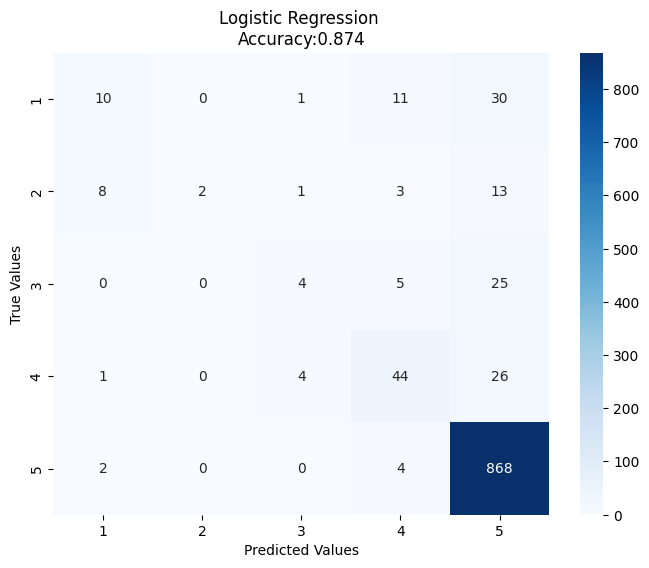

In [ ]:
target_names = ["1","2","3","4","5"]
cm_df = pd.DataFrame(cm,
index = target_names,
columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,
y_pred)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def predictor(text, vectorizer, model, processor):
  df_test = pd.DataFrame([text], columns=['content'])
  processor.df = df_test
  df_test = processor.main_process()
  somebody_feedback = vectorizer.transform(df_test['processed'])
  result = model.predict(somebody_feedback)[0]
  if result in (1,2):
    return 'negative'
  elif result in (4,5):
    return 'positive'
  else:
    return 'neutral'
print(predictor('Cần đúng với mô tả. Chất lượng cần tốt hơn. chọn màu cho bé gái mà giao toàn màu tối, cổ áo vải bị xước nữa, shop bán hàng chán thật', vectorizer, model, processor))

negative


Naive Bayes model

In [ ]:
# multinomialNB xử lý discrete value ổn hơn bernulie và gaussian
from sklearn.naive_bayes import MultinomialNB
x = vectorizer.transform(processed_df['processed']).toarray()
y = df['rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [ ]:
# tỉ lệ chính xác trên tập train
model.score(x_train, y_train)

0.8360810174281676

In [ ]:
# tỉ lệ chính xác trên tập test
model.score(x_test, y_test)

0.8380414312617702

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
print("Accuracy is ", accuracy_score(y_test,y_pred)*100,"%")

Accuracy is  83.80414312617702 %


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[  8,   0,   0,   1,  43],
       [  9,   0,   0,   2,  16],
       [  0,   0,   1,   0,  33],
       [  1,   0,   1,  10,  63],
       [  3,   0,   0,   0, 871]])

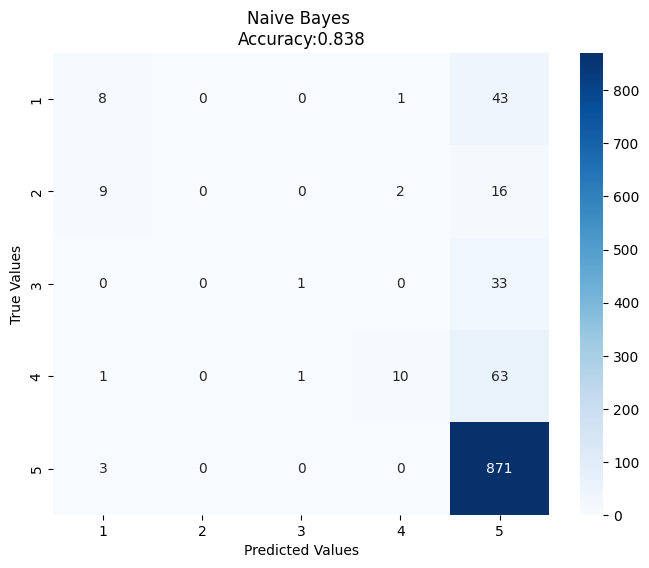

In [ ]:
target_names = ["1","2","3","4","5"]
cm_df = pd.DataFrame(cm,
index = target_names,
columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,
y_pred)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def predictor(text, vectorizer, model, processor):
  df_test = pd.DataFrame([text], columns=['content'])
  processor.df = df_test
  df_test = processor.main_process()
  somebody_feedback = vectorizer.transform(df_test['processed']).toarray()
  result = model.predict(somebody_feedback)[0]
  if result in (1,2):
    return 'negative'
  elif result in (4,5):
    return 'positive'
  else:
    return 'neutral'
print(predictor('Cần đúng với mô tả. Chất lượng cần tốt hơn. chọn màu cho bé gái mà giao toàn màu tối, cổ áo vải bị xước nữa, shop bán hàng chán thật', vectorizer, model, processor))

negative


Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
x = vectorizer.transform(processed_df['processed'])
y = df['rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# tỉ lệ chính xác trên tập train
model.score(x_train, y_train)

0.9194536033914272

In [ ]:
# tỉ lệ chính xác trên tập test
model.score(x_test, y_test)

0.8757062146892656

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
print("Accuracy is ", accuracy_score(y_test,y_pred)*100,"%")

Accuracy is  87.57062146892656 %


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 12,   2,   2,  11,  25],
       [  7,   4,   0,   3,  13],
       [  0,   1,  10,   6,  17],
       [  2,   1,   4,  45,  23],
       [  4,   2,   3,   6, 859]])

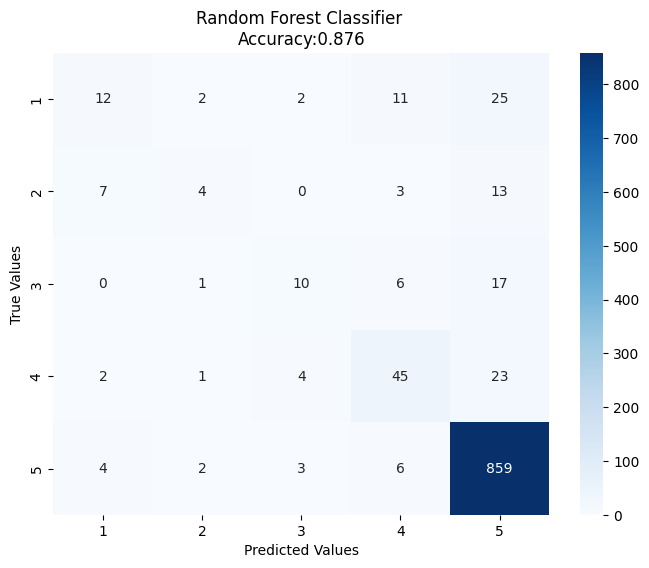

In [ ]:
target_names = ["1","2","3","4","5"]
cm_df = pd.DataFrame(cm,
index = target_names,
columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Random Forest Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,
y_pred)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def predictor(text, vectorizer, model, processor):
  df_test = pd.DataFrame([text], columns=['content'])
  processor.df = df_test
  df_test = processor.main_process()
  somebody_feedback = vectorizer.transform(df_test['processed'])
  result = model.predict(somebody_feedback)[0]
  if result in (1,2):
    return 'negative'
  elif result in (4,5):
    return 'positive'
  else:
    return 'neutral'
print(predictor('Cần đúng với mô tả. Chất lượng cần tốt hơn. chọn màu cho bé gái mà giao toàn màu tối, cổ áo vải bị xước nữa, shop bán hàng chán thật', vectorizer, model, processor))

negative


### With big data

Logistic Regression

In [ ]:
!pip install findspark
!pip install pyspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

In [ ]:
spark = SparkSession.builder.appName('rating_classification').getOrCreate()

In [ ]:
df = spark.createDataFrame(processed_df)

In [ ]:
df = df.select('processed','rating')

In [ ]:
df.show()

+--------------------+------+
|           processed|rating|
+--------------------+------+
|    shop phục_vụ tốt|     4|
|      sản_phẩm mô_tả|     3|
|                hàng|     5|
|sản_phẩm dịch_vụ ...|     4|
|sản_phẩm dịch_vụ ...|     5|
|shop tư_vấn hướng...|     5|
|    sản_phẩm tốt đợi|     5|
|      sản_phẩm mô_tả|     4|
|            hài_lòng|     5|
|sản_phẩm hàng chó...|     5|
|chuyên_nghiệp thâ...|     5|
|sản_phẩm dịch_vụ ...|     5|
|    sản_phẩm tốt đợi|     5|
|    sản_phẩm tốt đợi|     5|
|      sản_phẩm mô_tả|     4|
|    sản_phẩm tốt đợi|     5|
|chất_lượng tuyệt_vời|     5|
|    sản_phẩm tốt đợi|     5|
|sản_phẩm dịch_vụ ...|     5|
|sản_phẩm dịch_vụ ...|     5|
+--------------------+------+
only showing top 20 rows



In [ ]:
tokenizer = Tokenizer(inputCol="processed", outputCol="words")
wordsData = tokenizer.transform(df)
wordsData.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------+------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|processed                                                                                                                     |rating|words                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------+------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|shop phục_vụ tốt                                                                                                              |4     |[shop, phục_vụ, tốt

In [ ]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.select("rating", "features").show(truncate=False)

+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|features                                                                                                                                                                                              |
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|4     |(20,[2,7,11],[0.5213663216059017,0.7162024077072823,0.6119604819714956])                                                                                                                              |
|3     |(20,[7,9],[0.7162024077072823,0.4160692597378743])                                                                                                              

Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

In [ ]:
log_reg_sendo = LogisticRegression(featuresCol='features', labelCol='rating')

In [ ]:
train_data, test_data = rescaledData.randomSplit([0.8,.2])

In [ ]:
fit_model = log_reg_sendo.fit(train_data)

In [ ]:
results = fit_model.transform(test_data)

In [ ]:
results.select('rating','prediction').show(5)

+------+----------+
|rating|prediction|
+------+----------+
|     1|       5.0|
|     3|       5.0|
|     5|       5.0|
|     5|       5.0|
|     5|       5.0|
+------+----------+
only showing top 5 rows



In [ ]:
preds_and_labels = results.select(['prediction','rating']).withColumn('rating', col('rating').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


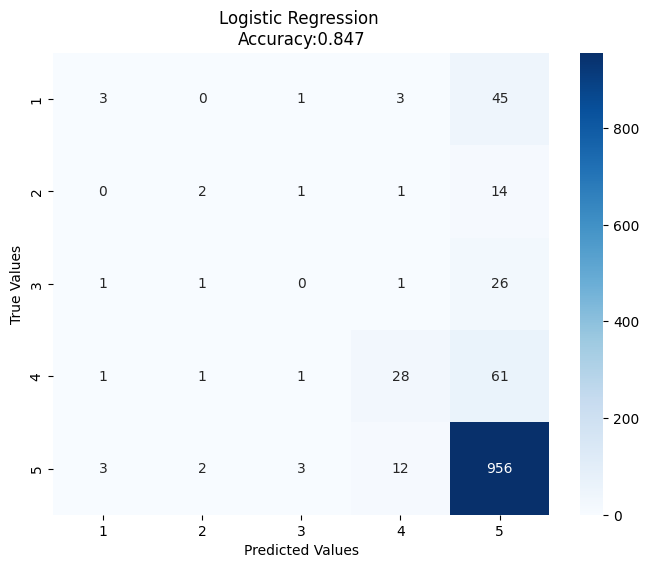

In [ ]:
cm = metrics.confusionMatrix().toArray()
target_names = ["1","2","3","4","5"]
cm_df = pd.DataFrame(cm,
index = target_names,
columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(metrics.accuracy))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def predictor_bd(text, fit_model, processor):
  df_test = pd.DataFrame([text], columns=['content'])
  processor.df = df_test
  df_test = processor.main_process()
  df = spark.createDataFrame(df_test)
  tokenizer = Tokenizer(inputCol="processed", outputCol="words")
  wordsData = tokenizer.transform(df)
  wordsData.show(truncate=False)
  hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
  featurizedData = hashingTF.transform(wordsData)
  idf = IDF(inputCol="rawFeatures", outputCol="features")
  idfModel = idf.fit(featurizedData)
  rescaledData = idfModel.transform(featurizedData)
  rescaledData.select("features").show(truncate=False)
  row_list = fit_model.transform(rescaledData).select('prediction').collect()
  result = row_list[0].__getitem__('prediction')
  print(result)
  if result in (1,2):
    return 'negative'
  elif result in (4,5):
    return 'positive'
  else:
    return 'neutral'
print(predictor_bd('Cần đúng với mô tả. Chất lượng cần tốt hơn. chọn màu cho bé gái mà giao toàn màu tối, cổ áo vải bị xước nữa, shop bán hàng chán thật', fit_model, processor))

+------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|content                                                                                                                             |processed                                                                 |words                                                                                      |
+------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|Cần đúng với mô tả. Chất lượng cần tốt hơn. chọn màu cho bé gái mà giao toàn màu tối, cổ áo v

Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(labelCol='rating',featuresCol='features')

In [ ]:
train_data, test_data = rescaledData.randomSplit([0.8,.2])

In [ ]:
fit_model = rfc.fit(train_data)

In [ ]:
results = fit_model.transform(test_data)

In [ ]:
results.select('rating','prediction').show(5)

+------+----------+
|rating|prediction|
+------+----------+
|     5|       5.0|
|     5|       5.0|
|     5|       5.0|
|     5|       5.0|
|     5|       5.0|
+------+----------+
only showing top 5 rows



In [ ]:
preds_and_labels = results.select(['prediction','rating']).withColumn('rating', col('rating').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


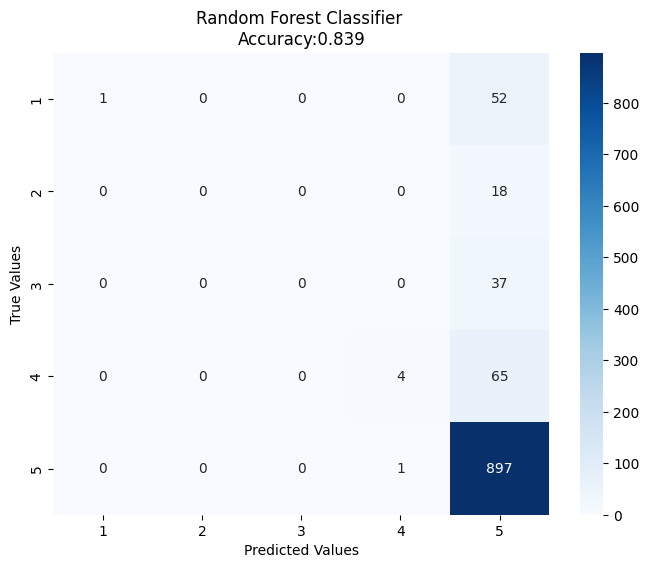

In [ ]:
cm = metrics.confusionMatrix().toArray()
target_names = ["1","2","3","4","5"]
cm_df = pd.DataFrame(cm,
index = target_names,
columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Random Forest Classifier \nAccuracy:{0:.3f}'.format(metrics.accuracy))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(predictor_bd('Cần đúng với mô tả. Sai kích thước nhiều quá. Cho trẻ 10-12kg. Con mình 8,4kg (12tháng) mà ko vừa háng bẹn,', fit_model, processor))

+-----------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------------+
|content                                                                                                    |processed                              |words                                         |
+-----------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------------+
|Cần đúng với mô tả. Sai kích thước nhiều quá. Cho trẻ 10-12kg. Con mình 8,4kg (12tháng) mà ko vừa háng bẹn,|mô_tả kích_thước trẻ không_vừa háng bẹn|[mô_tả, kích_thước, trẻ, không_vừa, háng, bẹn]|
+-----------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------------+

+-------------

In [ ]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

Decision tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier(featuresCol='features',labelCol='rating')

In [ ]:
train_data, test_data = rescaledData.randomSplit([0.8,.2])

In [ ]:
fit_model = dtc.fit(train_data)

In [ ]:
results = fit_model.transform(test_data)

In [ ]:
results.select('rating','prediction').show(5)

+------+----------+
|rating|prediction|
+------+----------+
|     1|       5.0|
|     1|       5.0|
|     4|       5.0|
|     5|       5.0|
|     5|       5.0|
+------+----------+
only showing top 5 rows



In [ ]:
preds_and_labels = results.select(['prediction','rating']).withColumn('rating', col('rating').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


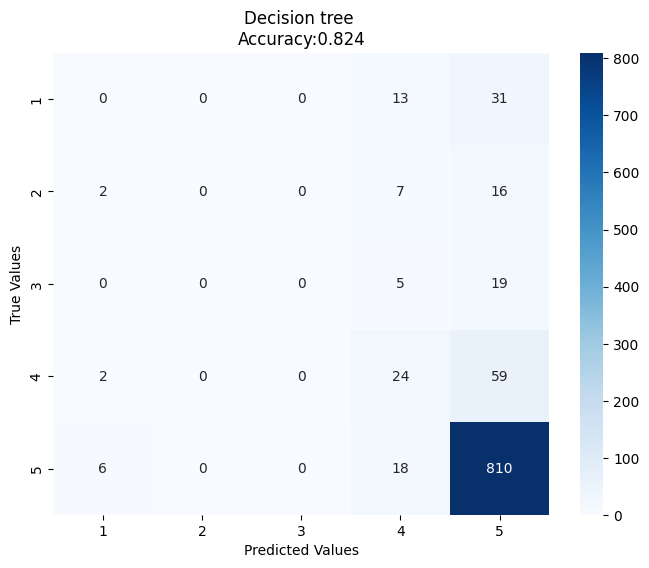

In [ ]:
cm = metrics.confusionMatrix().toArray()
target_names = ["1","2","3","4","5"]
cm_df = pd.DataFrame(cm,
index = target_names,
columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Decision tree \nAccuracy:{0:.3f}'.format(metrics.accuracy))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(predictor_bd('Cần đúng với mô tả. Sai kích thước nhiều quá. Cho trẻ 10-12kg. Con mình 8,4kg (12tháng) mà ko vừa háng bẹn,', fit_model, processor))

+-----------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------------+
|content                                                                                                    |processed                              |words                                         |
+-----------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------------+
|Cần đúng với mô tả. Sai kích thước nhiều quá. Cho trẻ 10-12kg. Con mình 8,4kg (12tháng) mà ko vừa háng bẹn,|mô_tả kích_thước trẻ không_vừa háng bẹn|[mô_tả, kích_thước, trẻ, không_vừa, háng, bẹn]|
+-----------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------------+

+-------------